In [1]:
import pandas as pd
import numpy as np

data = np.load('distorted_data/concatenated_data.npz')
print(len(data['original']), list(data.keys()))
data

# # load the data from every file in the distorted_data directory

# import os
# data_dir = 'distorted_data'

# data = []
# for filename in os.listdir(data_dir):
#     if filename.endswith('.npz'):
#         file_path = os.path.join(data_dir, filename)
#         loaded_data = np.load(file_path)
#         data.append(loaded_data)

# # concatenate the data from all files
# all_data = {}
# for key in data[0].keys():
#     all_data[key] = np.concatenate([d[key] for d in data], axis=0)

# # check the shape of the concatenated data
# for key, value in all_data.items():
#     print(f"{key}: {value.shape}")

# # save the concatenated data to a new npz file
# output_file = 'distorted_data/concatenated_data.npz'
# np.savez(output_file, **all_data)

34561 ['original', 'label', 'Uniform_Noise', 'Rotate_90deg']


In [2]:
keys = list(data.keys())

images = [data[keys[0]], data[keys[2]], data[keys[3]]]
labels = data[keys[1]]

In [3]:
images[0][0]

array([[0.25490198, 0.25490198, 0.25490198, ..., 0.21960784, 0.21960784,
        0.21960784],
       [0.25490198, 0.25490198, 0.25490198, ..., 0.21960784, 0.21960784,
        0.21960784],
       [0.25490198, 0.25490198, 0.25490198, ..., 0.21960784, 0.21960784,
        0.21960784],
       ...,
       [0.29411766, 0.29411766, 0.29411766, ..., 0.20784314, 0.20784314,
        0.20784314],
       [0.29411766, 0.29411766, 0.29411766, ..., 0.20784314, 0.20784314,
        0.20784314],
       [0.29411766, 0.29411766, 0.29411766, ..., 0.20784314, 0.20784314,
        0.20784314]], dtype=float32)

In [4]:
def normalize_image(image, mean=0.5, std=0.5):
    """
    Normalize an image tensor to have a mean and standard deviation.
    """
    return (image - mean) / std

def normalize_images(images, mean=0.5, std=0.5):
    """
    Normalize a list of images.
    """
    return [normalize_image(image, mean, std) for image in images]

In [5]:
normalized_images = []
for image in images:
    normalized_images.append(normalize_images(image))

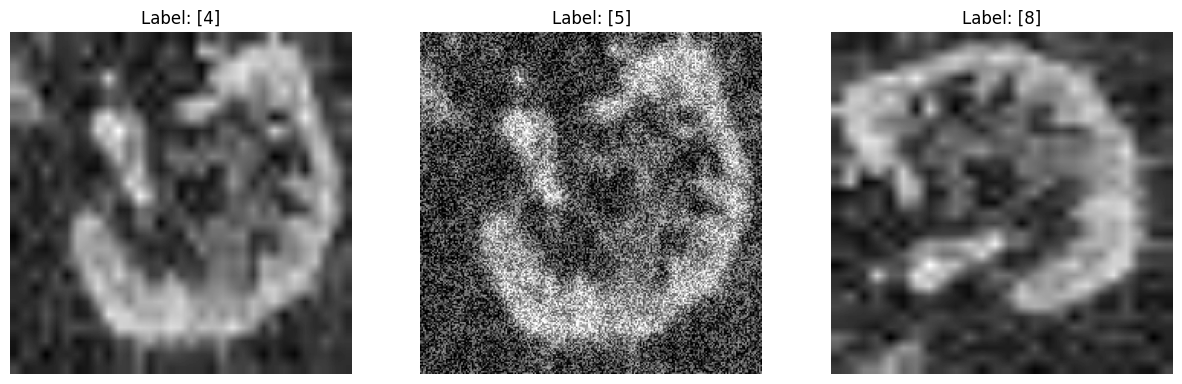

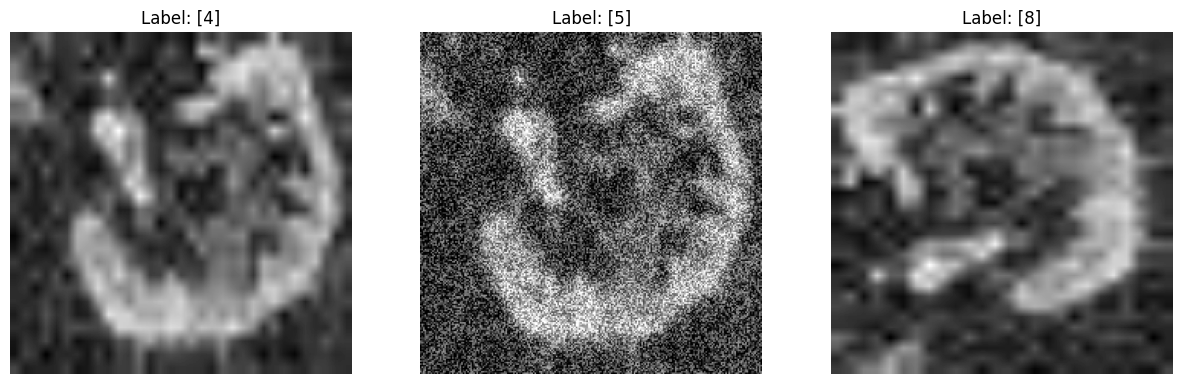

In [6]:
def plot_sample_images(images, labels, n=3):
    """
    Plot a sample of images with their corresponding labels.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

plot_sample_images(images, labels)
plot_sample_images(normalized_images, labels)

In [7]:
images[0][0]

array([[0.25490198, 0.25490198, 0.25490198, ..., 0.21960784, 0.21960784,
        0.21960784],
       [0.25490198, 0.25490198, 0.25490198, ..., 0.21960784, 0.21960784,
        0.21960784],
       [0.25490198, 0.25490198, 0.25490198, ..., 0.21960784, 0.21960784,
        0.21960784],
       ...,
       [0.29411766, 0.29411766, 0.29411766, ..., 0.20784314, 0.20784314,
        0.20784314],
       [0.29411766, 0.29411766, 0.29411766, ..., 0.20784314, 0.20784314,
        0.20784314],
       [0.29411766, 0.29411766, 0.29411766, ..., 0.20784314, 0.20784314,
        0.20784314]], dtype=float32)

In [8]:
normalized_images[0][0]

array([[-0.49019605, -0.49019605, -0.49019605, ..., -0.56078434,
        -0.56078434, -0.56078434],
       [-0.49019605, -0.49019605, -0.49019605, ..., -0.56078434,
        -0.56078434, -0.56078434],
       [-0.49019605, -0.49019605, -0.49019605, ..., -0.56078434,
        -0.56078434, -0.56078434],
       ...,
       [-0.41176468, -0.41176468, -0.41176468, ..., -0.58431375,
        -0.58431375, -0.58431375],
       [-0.41176468, -0.41176468, -0.41176468, ..., -0.58431375,
        -0.58431375, -0.58431375],
       [-0.41176468, -0.41176468, -0.41176468, ..., -0.58431375,
        -0.58431375, -0.58431375]], dtype=float32)

In [9]:
type(normalized_images[0][0])
normalized_images[0][0].shape

(224, 224)

In [10]:
zero_labels = np.zeros_like(labels)
one_labels = np.ones_like(labels)

print(zero_labels.shape, one_labels.shape)

domain_labels = np.concatenate((zero_labels, one_labels, one_labels), axis=0)
print(domain_labels.shape)

expanded_labels = np.concatenate((labels, labels, labels), axis=0)
print(expanded_labels.shape)

(34561, 1) (34561, 1)
(103683, 1)
(103683, 1)


In [11]:
# concatenate the matrices in the images list
concatenated_images = np.concatenate(normalized_images, axis=0)
concatenated_images.shape

(103683, 224, 224)

In [12]:
import branched_resnet as br 
from branched_resnet import CustomImageDataset
from transformers import Trainer, TrainingArguments, PreTrainedModel, ResNetConfig

config = ResNetConfig()
model = br.ResNetForMultiLabel(config=config, num_d1_classes=11, num_d2_classes=2)

for name, param in model.named_parameters():
    print(name, param.data.mean(), param.requires_grad)
    break

train_ds = CustomImageDataset(images=concatenated_images, labels1=expanded_labels, labels2=domain_labels)


resnet.embedder.embedder.convolution.weight tensor(-7.4323e-05) True


# D20

Train on undistorted and rotate 90

Test on the rest

In [ ]:
trainer = br.train_model(train_dataset=train_ds, eval_dataset= train_ds, model=model, num_epochs=50)
trainer.save_model('branched_resnet_model_2')

C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: samuelsavine (samuelsavine-johns-hopkins-university). Use `wandb login --relogin` to force relogin


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss
